# Fake News Detection in R
### using lexical data and text complexity

# Import libraries

In [4]:
library(tidyverse)
library(magrittr)
library(quanteda)
library(tidytext)
library(quanteda.textstats)
library(caret)
library(e1071)
library(Boruta) # random forest feature selection
# install.packages('quanteda.textstats')

# Load data and Preprocessing

In [5]:
df <- readRDS(file="data.rds")
summary(df)

       X               id           title              author         
 Min.   :    2   Min.   :    1   Length:1951        Length:1951       
 1st Qu.: 5241   1st Qu.: 5240   Class :character   Class :character  
 Median :10335   Median :10334   Mode  :character   Mode  :character  
 Mean   :10379   Mean   :10378                                        
 3rd Qu.:15514   3rd Qu.:15512                                        
 Max.   :20800   Max.   :20799                                        
     text               label       
 Length:1951        Min.   :0.0000  
 Class :character   1st Qu.:0.0000  
 Mode  :character   Median :1.0000  
                    Mean   :0.5023  
                    3rd Qu.:1.0000  
                    Max.   :1.0000  

In [4]:
df.corp <- corpus(df) # create corpus

In [5]:
# document-feature matrix
df.mat = df.corp %>% 
          tokens(remove_punct = T) %>% 
          dfm %>% dfm_remove(stopwords("english")) %>% 
          dfm_wordstem()
df.mat

Document-feature matrix of: 1,951 documents, 42,649 features (99.39% sparse) and 5 docvars.
       features
docs    0 comment video upload 2013 call marin vs thug near
  text1 1       1     1      1    1    1     2  1    3    1
  text2 0       0     0      0    0    1     0  0    0    0
  text3 0       0     0      0    0    0     0  0    0    2
  text4 1       1     0      0    0    0     0  0    0    0
  text5 0       0     1      0    0    0     0  0    0    4
  text6 0       0     0      0    0    0     0  0    0    0
[ reached max_ndoc ... 1,945 more documents, reached max_nfeat ... 42,639 more features ]

In [6]:
# calculate FOG's readability - ratio of sentences to words and number of complex words
fog = df.corp %>%
    textstat_readability(measure = "FOG") 

# lexical diversity Herdan's C = logV/logN, and TTR - Type-Token Ratio = V/M (V-tokens, M-text length)
df.lex = df.mat %>%
    textstat_lexdiv(measure = c("TTR", "C")) 



In [7]:
# calculate stats for each documnt: chars, words etc.
df_attr = df.corp %>%
    textstat_summary(., cache = TRUE)%>%
    select(document,chars,sents,tokens,types,puncts,numbers)

# add FOG, C, TTR
df_attr = df_attr %>% 
  left_join(fog) %>% 
  left_join(df.lex)%>% 
  select(-c(document))

Warning message:
“cache argument is not used.”
Joining with `by = join_by(document)`
Joining with `by = join_by(document)`


In [10]:
# classes = fake news/true news
class = as.factor(df$label)
data <- cbind(df_attr, class.out = class)
data = na.omit(data) # remove nans

In [16]:
head(data)

,chars,sents,tokens,types,puncts,numbers,FOG,TTR,C,class.out
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,422,5,86,68,13,2,10.24432,0.9069767,0.9740406,1
2,2522,14,485,230,66,1,18.65401,0.6530612,0.9225478,0
3,7420,55,1430,574,175,22,14.41811,0.6214689,0.9275164,0
4,1803,11,355,197,41,2,17.27805,0.7556818,0.9458204,1
5,3093,21,585,275,61,6,16.46950,0.6688963,0.9294570,0
6,407,3,73,60,15,6,18.07816,0.8604651,0.9600441,1


In [18]:
# split data to train and test
input <- createDataPartition(data$class, p = 0.8, list = F)

data.train <- data[input,]
data.test <- data[-input,]

# FIT

In [23]:
# model:SVM linear kernel, 10-fold crossvalidation
fit <- trainControl(method = "cv", number = 10)
model1 <- train(class.out ~ ., data = data.train, method = "svmLinear", trControl = fit)
model1

Support Vector Machines with Linear Kernel 

1548 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1393, 1393, 1394, 1393, 1394, 1393, ... 
Resampling results:

  Accuracy   Kappa    
  0.6814766  0.3630787

Tuning parameter 'C' was held constant at a value of 1

In [24]:
# model:SVM radial kernel, 10-fold crossvalidation
fit <- trainControl(method = "cv", number = 10)
model2 <- train(class.out ~ ., data = data.train, method = "svmRadial", trControl = fit)
model2

Support Vector Machines with Radial Basis Function Kernel 

1548 samples
   9 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1393, 1392, 1394, 1393, 1394, 1393, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.6672328  0.3343057
  0.50  0.6788625  0.3575518
  1.00  0.6878949  0.3757155

Tuning parameter 'sigma' was held constant at a value of 0.3210158
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.3210158 and C = 1.

# Predict

In [36]:
# predict using model2
prediction = predict(model2, data.test)

# confusion matrix
CM = table(data.test$class.out, prediction)
print(CM)
print("")
print("Test set Accuracy")
print(sum(diag(CM)) / sum(CM))

   prediction
      0   1
  0 133  61
  1  65 127
[1] ""
[1] "Test set Accuracy"
[1] 0.6735751


### We have got accuracy ~69% on crossvalidated set and ~67% on test set!
The variance between sets is reasonable, and accuracy is decent given we used only lexical data without content of news' texts

# PCA - Principal Component Analysis
### what gives fake news away?

In [37]:
# perform PCA
test.pc <- princomp(~., cor=T, data=df_attr)
test.pc

Call:
princomp(formula = ~., data = df_attr, cor = T)

Standard deviations:
    Comp.1     Comp.2     Comp.3     Comp.4     Comp.5     Comp.6     Comp.7 
2.45039878 1.15694350 0.95202723 0.75141066 0.28322307 0.23619755 0.18809559 
    Comp.8     Comp.9 
0.11646543 0.03324154 

 9  variables and  1934 observations.

In [52]:
test.pc$sdev/sum(test.pc$sdev)

Comp.1      Comp.2      Comp.3      Comp.4      Comp.5      Comp.6 
0.397275851 0.187571802 0.154349337 0.121823971 0.045918112 0.038294004 
     Comp.7      Comp.8      Comp.9 
0.030495378 0.018882193 0.005389352

In [66]:
data.frame("Component relative variance"=c(test.pc$sdev/sum(test.pc$sdev))) 

,Component.relative.variance
,<dbl>
Comp.1,0.397275851
Comp.2,0.187571802
Comp.3,0.154349337
Comp.4,0.121823971
Comp.5,0.045918112
Comp.6,0.038294004
Comp.7,0.030495378
Comp.8,0.018882193
Comp.9,0.005389352


In [67]:
data.frame("Component cumulated variance"= cumsum(test.pc$sdev)/sum(test.pc$sdev))

,Component.cumulated.variance
,<dbl>
Comp.1,0.3972759
Comp.2,0.5848477
Comp.3,0.7391970
Comp.4,0.8610210
Comp.5,0.9069391
Comp.6,0.9452331
Comp.7,0.9757285
Comp.8,0.9946106
Comp.9,1.0000000


In [68]:
# features in components
test.pc$loadings


Loadings:
        Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8 Comp.9
chars    0.398                0.171         0.140  0.526  0.287  0.640
sents    0.383  0.210         0.151 -0.479  0.570 -0.463 -0.103       
tokens   0.399  0.121         0.151                0.379  0.268 -0.760
types    0.388  0.108         0.253  0.636        -0.137 -0.584       
puncts   0.388  0.170               -0.378 -0.790 -0.183              
numbers  0.281         0.238 -0.906  0.129  0.138                     
FOG            -0.540  0.810  0.157 -0.127                            
TTR     -0.314  0.482  0.297        -0.323         0.432 -0.536       
C       -0.241  0.600  0.403  0.128  0.282        -0.344  0.454       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8 Comp.9
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.111  0.111  0.111  0.111  0.111  0.111  0.111  0.111  0.111
Cumulative Var  0.111  0.222  0.333  0.444  

In [97]:
# Perform Boruta search
boruta_output <- Boruta(class.out ~ ., data=data, doTrace=0)  
# Do a tentative rough fix
roughFixMod <- TentativeRoughFix(boruta_output)
# Variable Importance Scores
imps <- attStats(roughFixMod)
imps2 = imps[imps$decision != 'Rejected', c('meanImp', 'decision')]
head(imps2[order(-imps2$meanImp), ])  # descending sort

Warning message in TentativeRoughFix(boruta_output):
“There are no Tentative attributes! Returning original object.”


,meanImp,decision
,<dbl>,<fct>
puncts,49.52594,Confirmed
FOG,27.26615,Confirmed
sents,24.54721,Confirmed
tokens,22.17483,Confirmed
types,19.40120,Confirmed
chars,17.93328,Confirmed


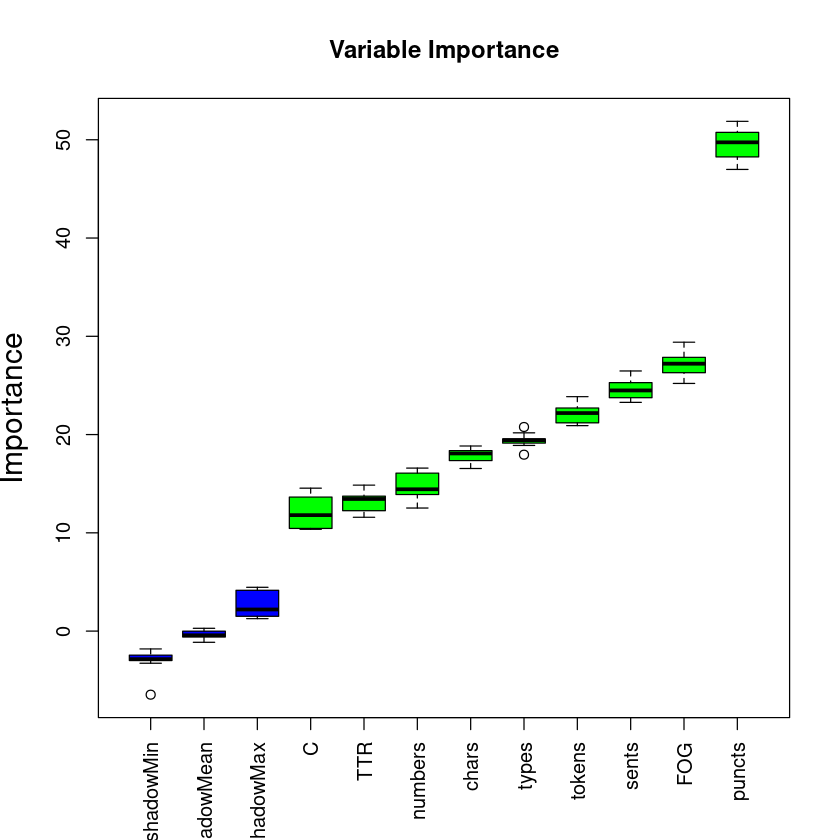

In [109]:
# Plot variable importance
# cex = element size
plot(boruta_output, cex.axis=1, cex.lab = 1.5, las=3, xlab="", main="Variable Importance")  